In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
sns.set_context('paper', font_scale=1.5)

heatmap_cmap = 'GnBu'

import scipy
from scipy.stats import ttest_rel, beta, ttest_ind
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
import numpy as np
import os
import yaml
import shutil
from collections import OrderedDict

from utils import quick_load_experiments_tsv, get_significance_by_column, add_probing_location_better_column
from common import lang2code, code2lang, lang2family, family2langs, lang2large_family

figure_dir = "fig/typology"
os.makedirs("fig", exist_ok=True)
os.makedirs(figure_dir, exist_ok=True)

np.random.seed(2)

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [18]:
model='xlm'
exps = pd.read_table(f"../dataframes/{model}_exps.tsv", sep="\t", quoting=3)
exps['tag'] = exps['task'].apply(lambda t: t.split("_")[0])
exps['pos'] = exps['task'].apply(lambda t: t.split("_")[1])
exps['full_task'] = exps['language'] + ' ' + exps['task']
exps['family'] = exps['language'].apply(lambda l: lang2family[l])

exps = add_probing_location_better_column(exps)
exps['probing_location_better'][exps.perturbation=='next1'] = True
exps['probing_location_better'][exps.perturbation=='next2'] = True
exps['perturbation'][exps.perturbation=='mBERT-rand-subw'] = 'rand-subw'

/tmp/ipykernel_16146/36603896.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exps['probing_location_better'][exps.perturbation=='next1'] = True
/tmp/ipykernel_16146/36603896.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exps['probing_location_better'][exps.perturbation=='next2'] = True
/tmp/ipykernel_16146/36603896.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exps['perturbation'][exps.perturbation=='mBERT-rand-subw'

In [19]:
exps

,model,language,task,perturbation,probing_location,dev_acc,test_acc,tag,pos,full_task,family,probing_location_better
0,XLM-RoBERTa,Afrikaans,number_noun,B$_2$,first,0.855000,0.850000,number,noun,Afrikaans number_noun,Germanic,False
1,XLM-RoBERTa,Afrikaans,number_noun,B$_2$,last,0.965000,0.971429,number,noun,Afrikaans number_noun,Germanic,True
2,XLM-RoBERTa,Afrikaans,number_noun,L$_2$,first,0.872857,0.862143,number,noun,Afrikaans number_noun,Germanic,False
3,XLM-RoBERTa,Afrikaans,number_noun,L$_2$,last,0.966429,0.979286,number,noun,Afrikaans number_noun,Germanic,True
4,XLM-RoBERTa,Afrikaans,number_noun,R$_2$,first,0.881429,0.842143,number,noun,Afrikaans number_noun,Germanic,False
...,...,...,...,...,...,...,...,...,...,...,...,...
5881,XLM-RoBERTa,Urdu,number_noun,permute,last,0.964286,0.907143,number,noun,Urdu number_noun,Indic,True
5882,XLM-RoBERTa,Urdu,number_noun,prev1,last,0.949286,0.874286,number,noun,Urdu number_noun,Indic,True
5883,XLM-RoBERTa,Urdu,number_noun,prev2,last,0.887857,0.786429,number,noun,Urdu number_noun,Indic,True
5884,XLM-RoBERTa,Urdu,number_noun,NaN,first,0.935714,0.902857,number,noun,Urdu number_noun,Indic,False


In [20]:
data_perturbations = ['TARG','L$_2$', 'R$_2$', 'B$_2$', 'permute']
model_perturbations = [
    'prev1',
    'next1',
    #'prev2',
    #'next2',
    'rand-subw',
]
baseline_models = []

In [23]:
bert_exps = exps[
    (exps.model=='XLM-RoBERTa') &
    (exps.probing_location_better==True)
]

bert_exps.shape

(3569, 12)

In [24]:
bert_exps.groupby(['language', 'task', 'perturbation'], dropna=False).size().value_counts()

1    3569
dtype: int64

In [25]:
unperturbed = bert_exps[bert_exps.perturbation.isnull()]
unperturbed = unperturbed.set_index(['language', 'task']).test_acc

In [26]:
perturbed = bert_exps[bert_exps.perturbation.isin(model_perturbations + data_perturbations)].pivot_table(
    index=['language', 'task'], columns='perturbation', values='test_acc'
)

In [27]:
test_effect = 100 * (1 - perturbed / unperturbed.values[:, None])

In [28]:
test_effect.mean()

perturbation
B$_2$         3.478948
L$_2$         1.232405
R$_2$         0.794370
TARG         13.845774
next1         9.848978
permute       5.155282
prev1         9.854908
rand-subw    19.483970
dtype: float64

In [29]:
#areas = pd.read_csv("../dataframes/wals/wals_areas.tsv", sep="\t")
#feat2area = dict(areas[['Name', 'Area']].drop_duplicates().values)
#feat2area['Family'] = 'Family'

terraling_languages = []
terraling = []
for fn in os.listdir('../dataframes/terraling'):
    if not fn.endswith('csv'):
        continue
    lang = fn.split(".")[0]
    terraling_languages.append(lang)
    df = pd.read_csv(f"../dataframes/terraling/{lang}.csv", encoding='latin1')
    df = df.sort_values('Name').pivot(index='Language', columns='Name', values='Value')
    terraling.append(df)

terraling = pd.concat(terraling, sort=True)
terraling.index = terraling_languages
terraling.loc['Slovak'] = np.nan
terraling.loc['Latvian'] = np.nan
terraling.loc['Urdu'] = np.nan
terraling = terraling.drop(columns=['latlong', 'ISO 639-3 Code'])
terraling['Family'] = terraling.index.map(lambda l: lang2family[l])
print(terraling.shape), terraling.isnull().stack().mean()

(39, 172)


(None, 0.3539057841383423)

In [30]:
te = test_effect[model_perturbations + data_perturbations].copy()
te['HAS_TASK'] = 1
logreg_perts = te.columns
te = te.unstack()
te = te.fillna(0)
te['HAS_TASK'] = te['HAS_TASK'].fillna(0)

In [40]:
lin_acc = []
K = 3

for col in terraling.columns:
    target = terraling[col].dropna()
    common = sorted(set(target.index) & set(te.index))
    label_cnt = target.value_counts()
    large_classes = label_cnt[label_cnt>=K]
    if len(large_classes) < 2:
        continue
    target = target[target.isin(large_classes.index)]
    if target.value_counts(normalize=True).max() > 0.8:
         continue
    if len(label_cnt) < 2:
        continue
    te_common = te.loc[target.index]
    for pert in logreg_perts:
        X = te_common[pert]
        score = cross_val_score(
            LogisticRegression(solver='liblinear', multi_class='auto', max_iter=200),
            X, target, cv=3, scoring='f1_macro')
        notnull = len(target)
        lin_acc.append({
            'perturbation': pert, 'feature': col, 'score': score.mean(),
            'notnull': notnull, 'labels': dict(target.value_counts())})
    X = te_common
    score = cross_val_score(LogisticRegression(
        solver='liblinear', multi_class='auto', max_iter=200), X, target, cv=3, scoring='f1_macro')
    notnull = len(target)
    lin_acc.append({'perturbation': 'ALL', 'feature': col, 'score': score.mean(),
                    'notnull': notnull, 'labels': dict(target.value_counts())})
lin_acc = pd.DataFrame(lin_acc)

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

In [32]:
pd.set_option('display.max_rows', 500)
l = lin_acc.sort_values('score', ascending=False).copy()

In [33]:
l.head(15)

,perturbation,feature,score,notnull,labels
646,B$_2$,S03_1 Indef Sg count Ns (Subj) can be bare,1.000000,14,"{'No': 9, 'Yes': 5}"
592,rand-subw,S01A1_ Existential constructions: locative PP ...,1.000000,13,"{'No': 9, 'Yes': 4}"
652,rand-subw,S03_3 Indef Sg count Ns (Subj) must have an ar...,1.000000,13,"{'Yes': 9, 'No': 4}"
642,rand-subw,S03_1 Indef Sg count Ns (Subj) can be bare,0.920635,14,"{'No': 9, 'Yes': 5}"
659,ALL,S03_3 Indef Sg count Ns (Subj) must have an ar...,0.911111,13,"{'Yes': 9, 'No': 4}"
596,B$_2$,S01A1_ Existential constructions: locative PP ...,0.911111,13,"{'No': 9, 'Yes': 4}"
617,permute,S01B2_Ex: PN Subj,0.911111,12,"{'No': 7, 'Yes': 5}"
597,permute,S01A1_ Existential constructions: locative PP ...,0.911111,13,"{'No': 9, 'Yes': 4}"
332,rand-subw,O 06 4.2_DefPl_N-Art,0.902778,21,"{'No': 15, 'Yes': 6}"
479,ALL,Q09_Affirmative answer by V,0.899663,29,"{'Yes': 16, 'No': 13}"


In [34]:
l.perturbation = l.perturbation.str.replace('$', '')

/tmp/ipykernel_16146/1303587679.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  l.perturbation = l.perturbation.str.replace('$', '')


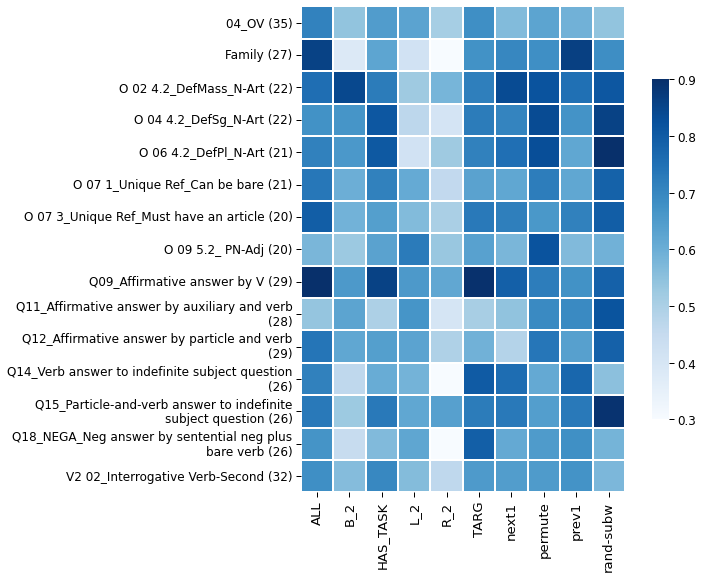

In [35]:
features = set(l[l['notnull']>=20].groupby('feature').score.mean().sort_values(ascending=False).head(15).index)

def wrap_text(text, maxline=40):
    lines = []
    this_line = []
    for word in text.split(" "):
        this_line.append(word)
        if sum(len(w) + 1 for w in this_line) - 1 >= maxline:
            lines.append(" ".join(this_line))
            this_line = []
    if this_line:
        lines.append(" ".join(this_line))
    return "\n".join(lines)
        
def plot_wals_pert_heatmap(data, save_fn=None, title=None):
    notnull = data[['feature', 'notnull']].drop_duplicates().set_index('feature')['notnull']
    table = data.pivot(index='feature', columns='perturbation', values='score')
    ysize = max(len(table), 6)
    max_text_len = data['feature'].str.len().max()
    scale = 'small' if max_text_len >= 85 else 'large'
    with matplotlib.rc_context(rc={'ytick.labelsize': 'large'}):
        fig, ax = plt.subplots(1, figsize=(12, 8))
        sns.heatmap(table, cmap='Blues', ax=ax, linewidth=.1, square=True, cbar_kws={'shrink': 0.7}, vmax=0.9, vmin=0.3)
        ticks = []
        for tick in ax.get_yticklabels():
            t = tick.get_text()
            t = "{} ({})".format(t, notnull.loc[t])
            tick.set_text(wrap_text(t))
            ticks.append(tick)
        ax.set_yticklabels(ticks)
        ax.set_ylabel("")
        ax.set_xlabel("")
        plt.subplots_adjust(left=0.5)
        plt.tight_layout()
        if title:
            ax.set_title(title)
        if save_fn:
            fig.savefig(save_fn, format='eps')
plot_wals_pert_heatmap(l[l.feature.isin(features)], save_fn=f"{figure_dir}/{model}_heatmap_terraling_logreg.eps")

In [182]:
lin_acc = []
K = 3

linreg_scores = []

for pert in model_perturbations + data_perturbations:
    target = test_effect[pert].mean(level=0)
    target = target.drop(['Slovak','Latvian','Urdu'])
    features = pd.get_dummies(terraling.drop(['Slovak','Latvian','Urdu']).fillna('Nan'))
    score = cross_val_score(
        SVR(),
        features, target, cv=3, scoring='neg_root_mean_squared_error')
    linreg_scores.append({'perturbation': pert, 'score': score.mean()})
linreg_scores = pd.DataFrame(linreg_scores)

/tmp/ipykernel_5337/1902077359.py:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  target = test_effect[pert].mean(level=0)
/tmp/ipykernel_5337/1902077359.py:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  target = test_effect[pert].mean(level=0)
/tmp/ipykernel_5337/1902077359.py:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  target = test_effect[pert].mean(level=0)
/tmp/ipykernel_5337/1902077359.py:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecat

In [183]:
linreg_scores

,perturbation,score
0,prev1,-3.179694
1,next1,-4.354972
2,L$_2$,-1.349842
3,R$_2$,-1.617697
4,B$_2$,-3.395468
5,permute,-4.551586


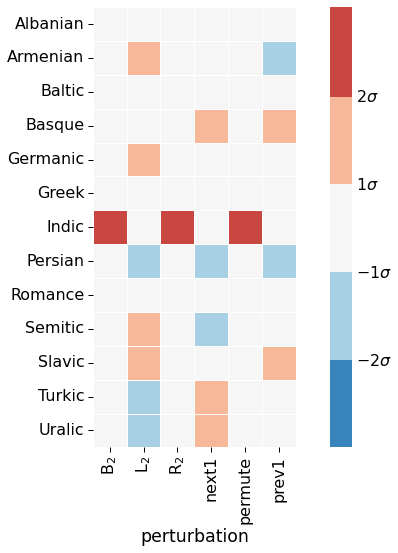

In [184]:
te = test_effect.reset_index()
te['family'] = te.language.apply(lambda l: lang2family[l])
te = te.groupby('family').mean()
te_std = te.std()
te_mean = te.mean()

te_discrete = pd.cut(((te - te_mean) / te_std).stack(), bins=[-1000, -2, -1, 1, 2, 1000], labels=[-2, -1, 0, 1, 2]).unstack().astype(int)
te_discrete
with sns.plotting_context('paper', font_scale=1.8):
    fig, ax = plt.subplots(1, figsize=(10, 8))
    sns.heatmap(te_discrete, ax=ax, cmap=sns.color_palette('RdBu_r', 5),
                linewidths=.5, vmin=-2, vmax=2, center=0, square=True)
    ax.set_ylabel("")
    colorbar = ax.collections[0].colorbar
    #colorbar.ax.set_frame_on(True)
    colorbar.ax.tick_params(size=0)
    ticklabels = [
        "$-2\sigma$",
        "$-1\sigma$",
        "$1\sigma$",
        "$2\sigma$",
    ]
    u = 2 / 2.5
    colorbar.set_ticks([-1.5*u, -0.5*u, 0.5*u, 1.5*u])
    colorbar.set_ticklabels(ticklabels)
    plt.tight_layout()
    fig.savefig(f"{figure_dir}/heatmap_family_effect_std_bin.pdf", bbox_inches='tight')

In [185]:
def do_cluster(K):
    #d = unfiltered['test_effect'][keep_perturbations]
    X = test_effect.pivot_table(index='language', columns='task')
    X = X.fillna(X.mean())
    k = KMeans(n_clusters=K)
    k.fit(X)
    clusters = [[] for _ in range(K)]
    for i, lab in enumerate(k.labels_):
        clusters[lab].append(X.index[i])
    print(f"K = {K}")
    print("\n------\n".join(", ".join(cl) for cl in clusters))
    
do_cluster(4)

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


K = 4
Afrikaans, Albanian, Armenian, Basque, Bulgarian, Catalan, Danish, Dutch, English, French, Greek, Hebrew, Hindi, Hungarian, Italian, Latin, Latvian, Lithuanian, Norwegian_Bokmal, Norwegian_Nynorsk, Persian, Polish, Portuguese, Romanian, Russian, Slovak, Spanish, Swedish, Turkish, Ukrainian, Urdu
------
Croatian, Czech, German, Serbian, Slovenian
------
Estonian, Finnish
------
Arabic


In [196]:
test_effect.pivot_table(index='language', columns='task').columns

MultiIndex([('B$_2$',   'animacy_adj'),
            ('B$_2$',  'animacy_noun'),
            ('B$_2$', 'animacy_propn'),
            ('B$_2$',  'animacy_verb'),
            ('B$_2$',    'aspect_adj'),
            ('B$_2$',   'aspect_verb'),
            ('B$_2$',      'case_adj'),
            ('B$_2$',     'case_noun'),
            ('B$_2$',    'case_propn'),
            ('B$_2$',     'case_verb'),
            ...
            ('prev1',   'person_verb'),
            ('prev1',  'polarity_adj'),
            ('prev1', 'polarity_verb'),
            ('prev1',   'subcat_verb'),
            ('prev1', 'subgender_adj'),
            ('prev1',     'tense_adj'),
            ('prev1',    'tense_verb'),
            ('prev1', 'verbform_verb'),
            ('prev1',     'voice_adj'),
            ('prev1',    'voice_verb')],
           names=['perturbation', 'task'], length=246)